# Semantic Segmentation on Google images


---



## WORKFLOW


- Analyze data - Exploratory Data Analysis (EDA)
  - Regression of Classification?
  - What is the target variable?
  - Is the data unbalanced?
  -  What are the features? Correlation, ranges, variances, values, NaN, errors...
  - Plot to make findings clearer
- Define the relevant metrics to be used
- Train a first baseline algorithm as a reference, e.g.:
  - For regression, train a model with all the features
  - For classification test basic models as the one-class-classifier (always the same class) and the basic
  logistic regression with all the features
  - If there is already a State of the Art solution, use it as an additional baseline
- Prepare data (where needed):
  - cleaning (e.g. remove NaN, outliers, ...)
  - normalization
  - shuffling and train, test and validation set construction
    - check the statistical properties of the splits
- Design experiments and define hyperparameters
- Repeat until performance on the test set is acceptable:
  - Train model and cross validate hyper parameters until acceptable performance on training set is
  achieved
  - Test best hyper parameter model and check if there is overfitting or underfitting
- Final Evaluation: ablation studies and failure modes

## Description

The image segmentation task as the objective to identify the objective in a generic photo. This could be a multi-class or binary image segmentation: the first need to identify all the objectives in a photo, for example, the cat, the human, the table and so on; the second one need only to identify the object and what is not the object, for example the cat and the other things are "not the cat".

In this notebook we will explore the image segmentation on photovoltaic panels in multi spectral satellitar images. We will use a UNET model for the task (see later on) and compare the results to identify the best outcomes and the difference between the prediction and the truth label.

##Summary


Photovoltaic (PV) energy generation plays a crucial role in the energy transition. Small-scale, residential PV installations are deployed at an unprecedented pace, and their safe integration into the grid necessitates up-to-date, high-quality information. Overhead imagery is increasingly used to improve the knowledge of residential PV installations with machine learning models capable of automatically mapping these installations. However, these models cannot be reliably transferred from one region or imagery source to another without incurring a decrease in accuracy. To address this issue, known as distribution shift, and foster the development of PV array mapping pipelines, we propose a dataset containing aerial images, segmentation masks, and installation metadata. We provide installation metadata for more than 28000 installations. We provide ground truth segmentation masks for 13000 installations, including 7000 with annotations for two different image providers. Finally, we provide installation metadata that matches the annotation for more than 8000 installations. Dataset applications include end-to-end PV registry construction, robust PV installations mapping, and analysis of crowdsourced datasets.

This dataset contains the complete records associated with the article "A crowdsourced dataset of aerial images of solar panels, their segmentation masks, and characteristics", published in Scientific data. The article is accessible here : https://www.nature.com/articles/s41597-023-01951-4

These complete records consist of:

1. The complete training dataset containing RGB overhead imagery, segmentation masks and metadata of PV installations (folder bdappv),
2. The raw crowdsourcing data, and the postprocessed data for replication and validation (folder data).
---
The description above is copied from the official page of the dataset.

The dataset can be found here: https://zenodo.org/records/7358126

The paper can be found here: https://www.nature.com/articles/s41597-023-01951-4

# About the dataset

---



### bdappv/ Root data folder



- google/ign:  One folder for each campaign
  - img/: Folder containing all the images presented to the users. This folder contains 28807 images for Google and 17325 images for IGN.
  - mask/: Folder containing all segmentations masks generated from the polygon annotations of the users. This folder contains 13303 masks for Google and 7686 masks for IGN.
- metadata.csv The .csv  file with the installations' metadata.


### data/ Root data folder

- raw/ Folder containing the raw crowdsourcing data and raw metadata;
  - input-google.json: .json input data data containing all information on images and raw annotators’ contributions for both phases (clicks and polygons) during the first annotation campaign;
  - input-ign.json: .json input data containing all information on images and raw annotators’ contributions for both phases (clicks and polygons) during the second annotation campaign;
  - raw-metadata.json: .json output containing the PV systems’ metadata extracted from the BDPV database before filtering. It can be used to replicate the association between the installations and the segmentation masks, as done in the notebook metadata.
- replication/ Folder containing the compiled data used to generate the segmentation masks;
  - campaign-google/campaign-ign: One folder for each campaign
    - click-analysis.json: .json output on the click analysis, compiling raw input into a few best-guess locations for the PV arrays. This dataset enables the replication of our annotations,
    - polygon-analysis.json: .json output of polygon analysis, compiling raw input into a best-guess polygon for the PV arrays.
- validation/ Folder containing the compiled data used for technical validation.
  - campaign-google/campaign-ign: One folder for each campaign
    - click-analysis-thres=1.0.json: .json output of the click analysis with a lowered threshold to analyze the effect of the threshold on image classification, as done in the notebook annotation;
    - polygon-analysis-thres=1.0.json: .json output of polygon analysis, with a lowered threshold to analyze the effect of the threshold on polygon annotation, as done in the notebook annotations.
  - metadata.csv: the .csv file of filtered installations' metadata.

# Import libraries & mounting Drive

---



### Mounting Drive

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

KeyboardInterrupt: 

### Import libraries

In [ ]:
# Plotting
%matplotlib inline
%reload_ext tensorboard
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
import albumentations as A

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, ConcatDataset, TensorDataset, random_split
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Utilites
import zipfile
import os
import requests
import shutil
import numpy as np
import pandas as pd
import sklearn
import random
from PIL import Image

from shutil import copyfile
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.5
    import pytorch_lightning as pl

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning import Trainer

# Wget
try:
    import wget
except ModuleNotFoundError: # Google Colab does not have wget installed by default. Hence, we do it here if necessary
    !pip install wget
    import wget

## Constant values and useful functions

In [ ]:
CAMPAIGN = "/google"

# The answer to anything
SEED = 42

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# URLS where you can find the dataset
BDAPPV_URL = 'https://zenodo.org/records/7358126/files/bdappv.zip?download=1'
DATA_URL = 'https://zenodo.org/records/7358126/files/data.zip?download=1'

URLS = [DATA_URL, BDAPPV_URL]

# Change this to save and extract files in different directories
SAVE_DIR = '/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset'
EXTRACT_DIR = '/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset'
IMG_DIR = '/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset/bdappv/google/img'
MASK_DIR = '/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset/bdappv/google/mask'

LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 3
NUM_WORKERS = 2
IMAGE_HEIGHT = 100
IMAGE_WIDTH = 100 # Original: 400 x 400
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/train/img"
TRAIN_MASK_DIR = "/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/train/mask"
VAL_IMG_DIR = "/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/validation/img"
VAL_MASK_DIR = "/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/validation/mask"
TEST_IMG_DIR = '/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/test/img'
TEST_MASK_DIR = '/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/test/mask'

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# Loading the dataset

---



In this section we will donwload all the folders needed from Zenodo (see [this section](https://colab.research.google.com/drive/1gi1CXB-m2aPufYSTBiFgnRidXj9tvEmy?authuser=3#scrollTo=36vlp-rmlhzt)). Where we will donwload it? On your Google Drive. All this process will be done only once. Make sure to have a stable Internet connection because it will take a while.

## Dowload and extract

In this section we will create the parent directory where we will store all the data.

In [ ]:
parent_dir = '/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation'

# Check if the parent directory exists, if not create it
if not os.path.exists(parent_dir):
    os.makedirs(parent_dir)

# Copy the current notebook to the parent directory
current_notebook = "google_semantic_segmentation_1950722.ipynb"
destination_notebook = os.path.join(parent_dir, current_notebook)

# Check if the notebook already exists in the parent directory, if not, copy it
if not os.path.exists(destination_notebook):
    copyfile(current_notebook, destination_notebook)

# Define the path for the dataset directory
dataset_dir = os.path.join(parent_dir, "dataset")

# Check if the dataset directory exists, if not create it
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

Here we donwload and extract the from the given url to our provided directory. To donwload the dataset change the variable `want_to_download`

In [ ]:
def download_and_extract(url, save_dir, extract_dir):
    # Get the filename from the URL
    filename = url.split('/')[-1]

    # Check if the file already exists
    if not os.path.exists(os.path.join(save_dir, filename)):
        # Download and extract the zip file
        with requests.get(url, stream=True) as r:
            with open(os.path.join(save_dir, filename), 'wb') as f:
                shutil.copyfileobj(r.raw, f)

        with zipfile.ZipFile(os.path.join(save_dir, filename), 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

        # Delete the zip file
        os.remove(os.path.join(save_dir, filename))
    else:
        print(f"Skipping installation of {filename}. File already exists.")

# Download and extract data from each URL
want_to_download = False # Change this to True to download the dataset
if want_to_download:
    print("Downloading the dataset... (this will take a while)")
    for url in URLS:
        print(f"Downloading data from {url}")
        download_and_extract(url, SAVE_DIR, EXTRACT_DIR)
else:
    print(f"To download the dataset, change the variable want_to_download, now setted to {want_to_download}")

## Checking files in each directory

The following code count every file in every subdirectory of the given directory (in this case, where we extract the data).
Check the number of files yourself:
- dataset: 0
    - dataset/data: 0
        - dataset/data/raw: 3
        - dataset/data/replication: 0
            - dataset/data/replication/campaign-google: 2
            - dataset/data/replication/campaign-ign: 2
        - dataset/data/validation: 1
            - dataset/data/validation/campaign-google: 2
            - dataset/data/validation/campaign-ign: 2
    - dataset/bdappv: 2
        - dataset/bdappv/google: 0
            - dataset/bdappv/google/img: 28807
            - dataset/bdappv/google/mask: 13303
        - dataset/bdappv/ign: 0
            - dataset/bdappv/ign/img: 17325
            - dataset/bdappv/ign/mask: 7685


In [ ]:
# Function to explore directories and count files
def explore_directories(directory):
    for root, dirs, files in os.walk(directory):
        print(f"Directory: {root}")
        print(f"Number of files: {len(files)}")
        print("-------------------------------------")

# Explore directories and count files
explore_directories(EXTRACT_DIR)

# Processing the images
---



Not all the images are interesenting and some images missing the labels. In this section we will make sure to have all the images ready.

## Filtering by size

Not all the images are actually interesting for the purpose and many of them (177) haven't any information in them, so we will delete it.

In [ ]:
small_images = []

for image_file in os.listdir(IMG_DIR):
    image_path = os.path.join(IMG_DIR, image_file)
    mask_path = os.path.join(MASK_DIR, image_file)

    # Check if image size is less than 10kb (10240 bytes)
    if os.path.isfile(image_path) and os.path.getsize(image_path) < 10240:
        small_images.append(image_file)
        os.remove(image_path)

print(f"Deleted {len(small_images)} images that weights less than 10kB")

## Adding masks for images without it

Many images are without label (almost 15 000). So with this code, if a image doens't have a mask, we will create a black label (label of all zeros) with the same name as the image.

In [ ]:
images_without_masks = []

for image_file in os.listdir(IMG_DIR):
    image_path = os.path.join(IMG_DIR, image_file)
    mask_path = os.path.join(MASK_DIR, image_file)
    mask_name = os.path.splitext(image_file)[0] + ".png"

    # Check if mask exists (else create an empty label)
    if not os.path.isfile(mask_path):
        images_without_masks.append(image_file)
        image = Image.open(image_path)
        mask = Image.new("RGB", image.size, color="black")
        mask.save(mask_path)

print(f"Added {len(images_without_masks)} empty labels for images without masks")

## Check if the numbers matches

Now check here if the images in the image directory and in the mask directory are the same

In [ ]:
img_files = os.listdir(IMG_DIR)
mask_files = os.listdir(MASK_DIR)

assert len(img_files) == len(mask_files), "Number of images and masks must be equal"
assert os.path.isdir(IMG_DIR), "Image directory does not exist"
assert os.path.isdir(MASK_DIR), "Mask directory does not exist"

print(f"You have {len(img_files)} images and {len(mask_files)} masks")
print(f"Image directory: {IMG_DIR}")
print(f"Mask directory: {MASK_DIR}")


# Exploratory Data Analysis

---



TODO: insert description of the section

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset/bdappv/metadata.csv')

## section

TODO: inserti description

In [ ]:
google_count = (df['GoogleControlled'] == True).sum()
ign_count = (df['IGNControlled'] == True).sum()
unknown_count = ((df['GoogleControlled'] == False) & (df['IGNControlled'] == False)).sum()

# Create bar plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['Google', 'IGN', 'Unknown'], [google_count, ign_count, unknown_count], color=['blue', 'green', 'orange'])
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Number of Images Controlled by Source')

# Create pie chart
plt.subplot(1, 2, 2)
labels = ['Google', 'IGN', 'Unknown']
sizes = [google_count, ign_count, unknown_count]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['blue', 'green', 'orange'])
plt.title('Percentage of Images Controlled by Source')

plt.tight_layout()
plt.show()

## Plot some samples

TODO: fix this basend on the constat value in the beginning


In [ ]:
img_files = [file for file in os.listdir(IMG_DIR) if file.endswith(('jpg', 'jpeg', 'png', 'bmp'))]
random_image_files = random.sample(img_files, 5)
set_seed(SEED)

plt.figure(figsize=(10, 15))
for i, random_image_file in enumerate(random_image_files, 1):
    # Get the image
    img_path = os.path.join(IMG_DIR, random_image_file)
    img = Image.open(img_path).convert('RGBA')

    # Get the mask
    mask_path = os.path.join(MASK_DIR, random_image_file)
    mask = Image.open(mask_path).convert('RGBA')

    # Create an overlay
    overlay = Image.blend(img, mask, alpha=0.7)

    # Set the position of each image
    plt.subplot(5, 3, 3*i-2)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(5, 3, 3*i-1)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(5, 3, 3*i)
    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Splitting the dataset

---



TODO: insert description of the section

## Splitting images into train, validation and test

TODO: inserti description

In [ ]:
# Shuffle the list of image files
random.shuffle(img_files)
set_seed(SEED)

# Calculate the sizes of train, validation, and test sets
num_images = len(img_files)
train_size = int(0.6 * num_images)  # 60% for training
val_size = int(0.2 * num_images)    # 20% for validation
test_size = num_images - train_size - val_size  # Remaining for testing

train_files = img_files[:train_size]
val_files = img_files[train_size:train_size + val_size]
test_files = img_files[train_size + val_size:]

# Print the number of images in each set
print(f"Number of training images: {len(train_files)}")
print(f"Number of validation images: {len(val_files)}")
print(f"Number of testing images: {len(test_files)}")
print(f"Total images: {len(train_files) + len(val_files) + len(test_files)}")

## Create new folders for the splitting

Be careful: this operation may take long. Also, make sure to not have folders with the same name into your parent directory.

This code makes three new directory and within each of them:
- **a file txt** where all the images name are given for the plit
- **img folder**, to store all the images in the given split
- **mask folder**, to store all the images in the given split

This operation is done only one time in your drive, then no more.

In [ ]:
train_path = os.path.join(parent_dir, 'train')
test_path = os.path.join(parent_dir, 'test')
val_path = os.path.join(parent_dir, 'validation')

files_paths = [
    (train_path, train_files),
    (test_path, test_files),
    (val_path, val_files)
]

for directory, file_list in files_paths:
    # Create main directory
    os.makedirs(directory, exist_ok=True)

    # Create subdirectories img and mask
    img_directory = os.path.join(directory, 'img/')
    mask_directory = os.path.join(directory, 'mask/')
    os.makedirs(img_directory, exist_ok=True)
    os.makedirs(mask_directory, exist_ok=True)

    # Create file path
    file_path = os.path.join(directory, f'{os.path.basename(directory)}.txt')

    # Check if file already exists
    if os.path.exists(file_path):
        print(f"Path to file already exists: {file_path}")
    else:
        print(f"Writing to file: {file_path}")
        content = []
        for file_name in file_list:
            image_path = os.path.join(IMG_DIR, file_name)
            mask_path = os.path.join(MASK_DIR, file_name)
            if os.path.exists(image_path) and os.path.exists(mask_path):
                content.append(file_name)
            else:
                raise ValueError("Path don't exist")

        # Write content to file
        with open(file_path, 'w') as file:
            file.write('\n'.join(content))

        with open(file_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                # Clean the line by removing leading and trailing whitespace and newline characters
                cleaned_line = line.strip()

                # Get the file paths for the image and mask
                img_file_path = os.path.join(IMG_DIR, cleaned_line)
                mask_file_path = os.path.join(MASK_DIR, cleaned_line)

                # Check if the image and mask files exist and copy them in the new dir
                if os.path.exists(img_file_path) and os.path.exists(mask_file_path):
                    shutil.copy(img_file_path, os.path.join(img_directory, cleaned_line))
                    shutil.copy(mask_file_path, os.path.join(mask_directory, cleaned_line))
                else:
                    print(f"Image or mask file does not exist for {cleaned_line}")


        print(f"Content for {file_path} written: {len(content)} lines")

Check every directory

In [ ]:
explore_directories(train_path)

In [ ]:
explore_directories(test_path)

In [ ]:
explore_directories(val_path)

Then clean up some unusued memory

In [ ]:
del img_files
del mask_files
del num_images
del train_size
del val_size
del test_size
del train_files
del val_files
del test_files
del files_paths

## Class GoogleDataset

TODO: inserti description

In [ ]:
class GoogleDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.image_dir, self.images[index])

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

# The model: U-Net

---



TODO: insert description of the section

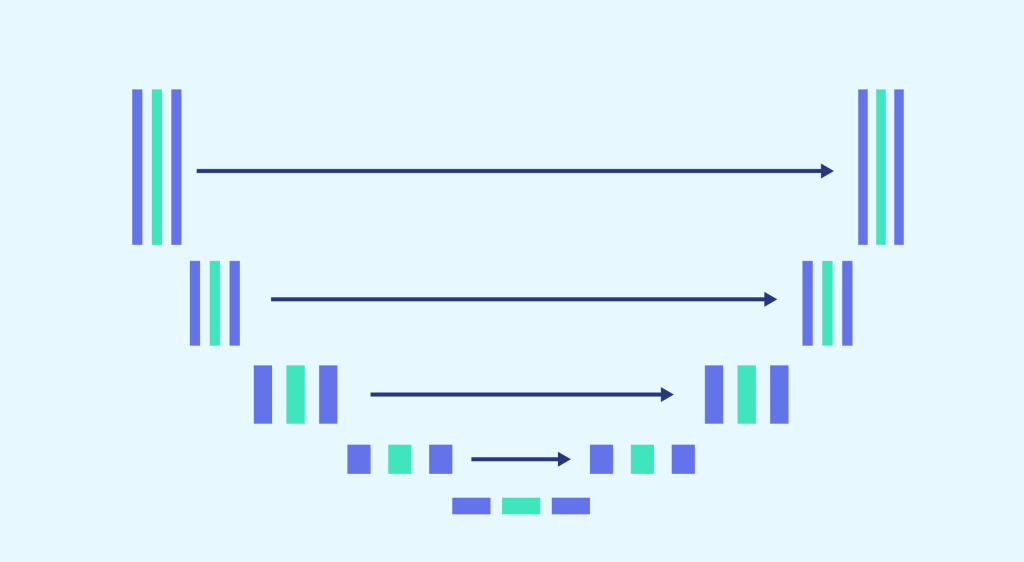

## U-NET implementation

TODO: inserti description

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

## section

TODO: inserti description

In [ ]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)

In questo modo il learning rate viene moltiplicato di default per 0.1 dopo un terzo delle epoche e di novo a due terzi del training e aiuta a convergere su un risultato migliore, permettendo anche di usare un learning rate iniziale maggiore.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer_SGD = torch.optim.SGD(model.parameters(), lr=0.01)

step_size = (NUM_EPOCHS // 3) + 1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size)
criterion = nn.BCEWithLogitsLoss()

## Train UNET

In [ ]:
baseline_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

train_set = GoogleDataset(image_dir = TRAIN_IMG_DIR, mask_dir = TRAIN_MASK_DIR, transform = baseline_transform)
val_set = GoogleDataset(image_dir = VAL_IMG_DIR, mask_dir = VAL_MASK_DIR, transform = baseline_transform)
test_set = GoogleDataset(image_dir = TEST_IMG_DIR, mask_dir = TEST_MASK_DIR, transform = baseline_transform)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=False,)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=False,)

In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = CarvanaDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = CarvanaDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()


LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 3
NUM_WORKERS = 2
IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "data/train_images/"
TRAIN_MASK_DIR = "data/train_masks/"
VAL_IMG_DIR = "data/val_images/"
VAL_MASK_DIR = "data/val_masks/"

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


    check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)

        # print some examples to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="saved_images/", device=DEVICE
        )


In [ ]:
main()

# The model: CHOOSE ANOTHER ONE
---



TODO: insert description of the section

## section

TODO: inserti description

# Dump



Come modello puoi usare una semplice U-net (o altro modello a tua scelta). Un buon tutorial per implementare UNET è il seguente: https://www.youtube.com/watch?v=IHq1t7NxS8k&ab_channel=AladdinPersson.




I training che dovrai eseguire sono almeno i seguenti:
- Baseline (prova diversi learning rate su scala logaritmica, una volta individuato il migliore passa al punto successivo)
- Aggiunta di data augmentation (almeno random horizontal/vertical flip, rotazioni di 0/90/180/270 gradi)
- Per questo dataset è importante provare anche ad aggiungere RandomCrop. Questo perché i pannelli solari, se sono presenti, sono quasi sempre al centro dell'immagine, e potrebbe non generalizzare bene a un caso reale.

Salvati tutti i training / pesi / grafici che fai, li vorrò vedere all'esame per vedere il lavoro fatto e le considerazioni che hai fatto.

I modelli migliori (sul validation) usali sul test set e segnati i risultati in una tabela (IoU per ogni classe, mIoU e overall accuracy).

Creati una repository GitHub dove puoi caricare di volta in volta il codice aggiornato. (Utile anche per dimostrare che il lavoro fatto è originale)